In [1]:
# Initialize the LLM
local_llm='llama3.1'

In [2]:
# Load parsed data which is in the form of Markdown
from llama_index.core import SimpleDirectoryReader
markdown_files = SimpleDirectoryReader(
    "C:/Users/s.vijaykumar/Desktop/skanda/bot/dataset/extracted_best/").load_data()

In [3]:
# load structured data which is in JSON format
import os
from llama_index.readers.json import JSONReader

reader = JSONReader()
directory_path = "C:/Users/s.vijaykumar/Desktop/skanda/bot/dataset/extracted_best/"
json_files = []
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):
        file_path = os.path.join(directory_path, filename)
        json_files.extend(reader.load_data(input_file=file_path, extra_info={}))
documents= markdown_files+json_files

In [4]:
## Restructure the metadata
from langchain.docstore.document import Document
new_documents = []
for document in documents:
    metadata = {
        'source': document.metadata,
        'Doc_id': document.id_
    }
    page_content = document.text
    new_document = Document(metadata=metadata, page_content=page_content)
    new_documents.append(new_document)

In [5]:
## Preprocessing:
from transformers import AutoTokenizer
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "","[","]"
]
## Remove define separates and filterout unnecessary space
from langchain.text_splitter import RecursiveCharacterTextSplitter
tokenizer = AutoTokenizer.from_pretrained("Alibaba-NLP/gte-large-en-v1.5")
## Use an embedding model to chunk data 
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=False,
    separators=MARKDOWN_SEPARATORS,
)
from tqdm import tqdm
documents2 = text_splitter.split_documents(new_documents)

## unique texts
# docs_processed3 = []
# unique_texts = {}
# for doc in tqdm(documents2):
#     new_docs = text_splitter.split_documents([doc])
#     for new_doc in new_docs:
#         docs_processed3.append(new_doc)

In [6]:
from langchain_community.vectorstores import FAISS
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
# Add embeded data to vectorDB
embedding_model = NomicEmbeddings(model="nomic-embed-text-v1", inference_mode="local")
vectordb = FAISS.from_documents(
    documents= documents2,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE   
)

In [7]:
## Define a  retriever
retriever=vectordb.as_retriever()

In [8]:
### Retrieval Grader
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
## define LLM with output format
llm = ChatOllama(model=local_llm, format="json", temperature=0)
## Prompt in the format of llama3
prompt = PromptTemplate(
    template="""
    Here is the retrieved document: \n\n {document} \n\n
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,input_variables=["question", "document"])
## Retrieval grader chain
retrieval_grader = prompt | llm | JsonOutputParser()
question = "DMM connector pitch size"
## Retirever gives output in list with most relevant results
docs = retriever.invoke(question)
## To get the relevant document
doc_txt = docs[1].page_content
## Push to LLM to check and verify if pulled data is right or not
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [9]:
### Generate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
# Prompt
prompt = PromptTemplate(
    template="""
    Context: {context} <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)
llm = ChatOllama(model=local_llm, temperature=0)
## Join all the results in the retrieved list
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
rag_chain = prompt | llm | StrOutputParser()
question = "What is the pitch size of CMM connector?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

2mm (also known as SUB-D TYPE)


In [10]:
### Hallucination Grader
llm = ChatOllama(model=local_llm, format="json", temperature=0)
## Prompt crafted to tell LLM to check whether the generated output is inline with what ever there is in the docs
prompt = PromptTemplate(template="""\n ------- \n{documents}\n ------- \n
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["documents","generation"]
)
hallucination_check = prompt | llm | JsonOutputParser()
hallucination_check.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [11]:
### Answer Grader
llm = ChatOllama(model=local_llm, format="json", temperature=0)
## Prompt crafter to check if the answer provided actually answers the user's question or not 
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'no'}

In [12]:
### Path router
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
llm = ChatOllama(model=local_llm, format="json", temperature=0)
## Pormpt crafted to go to retirever if answer is related to Nicomatic's connectors
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on Nicomatic's connectors, CMM, DMM, EMM and AMM.
    You do not need to be stringent with the keywords in the question related to these topics. 
    Otherwise, use web-search. Give a binary choice 'web_search'or 'vectorstore' based on the question. 
    Return the a JSON with a single key 'datasource' and no premable or explanation. 
    Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"])
question_router = prompt | llm | JsonOutputParser()
question = "what is the EMM connector pitch size"
print(question_router.invoke({"question": question}))

{'datasource': 'vectorstore'}


In [13]:
## Define web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
web= TavilySearchResults(k=4)

In [14]:
from pprint import pprint
from typing import List
from langchain_core.documents import Document
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

## Main Workflow
## Using Docstring to give hints and drive LLM to the right output
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

### Nodes of the graph
## retireves document 
def retrieve(state):
    """
    Retrieve documents from vectorstore
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("Retrieving info from docs....")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
## Generates response
def generate(state):
    """
    Generate answer using RAG on retrieved documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("LLM generating output....")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
# Checks if the generated response is right or not
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("Checking if any docs is relevant to the question....")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    ## Websearch set to No
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document is relevant
        if grade.lower() == "yes":
            print("---grade: docs is relevant---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---grade: docs not relevant---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
## Searches web and adds into doc
def web_search(state):
    """
    Web search based based on the question
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Appended web results to documents
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    docs = web.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}
### Conditional Nodes
## routs to either retierver or web search
def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("----Routing your question----")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---Routing your question to the internet---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---Routing your question to the doc retriever---")
        return "vectorstore"
## Routs to either generate response from LLM or search web
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("Checking with docs...")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    if web_search == "Yes":
        print(
            "Decision: none of the docs aligns with your question, lets try the internet---"
        )
        return "websearch"
    else:
        print("--DECISION: GENERATE---")
        return "generate"
## Check if answer is suitable for the asked question and is inline with the info inside the documents
def answer_good_or_not(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    print("---check hallucinations---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    # Check hallucination
    score = hallucination_check.invoke({"documents": documents, "generation": generation})
    grade = score["score"]
    if grade == "yes":
        print("---decision: generated output is relevant to the docs---")
        # Check question-answering
        print("---grade generated output with question asked---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---decision: generated output answers the question correctly---")
            return "useful"
        else:
            print("---decision: generated output does not answer the question---")
            return "not useful"
    else:
        pprint("---decision: generated output is not relevant, retry---")
        return "not generated right"

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)  
workflow.add_node("generate", generate)  

In [15]:
# Building the actual graph DAG
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve"})
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate"})
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    answer_good_or_not,
    {
        "not generated right": "generate",
        "useful": END,
        "not useful": "websearch"})

In [24]:
## Inference
from pprint import pprint
output= workflow.compile()

inputs = {"question": "What is the pitch size of a CMM, DMM, EMM and AMM connect?"}
for output in output.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

----Routing your question----
What is the pitch size of a CMM, DMM, EMM and AMM connect?
{'datasource': 'vectorstore'}
vectorstore
---Routing your question to the doc retriever---
Retrieving info from docs....
'Finished running: retrieve:'
Checking if any docs is relevant to the question....
---grade: docs is relevant---
---grade: docs is relevant---
---grade: docs is relevant---
---grade: docs is relevant---
Checking with docs...
--DECISION: GENERATE---
'Finished running: grade_documents:'
LLM generating output....
---check hallucinations---
---decision: generated output is relevant to the docs---
---grade generated output with question asked---
---decision: generated output does not answer the question---
'Finished running: generate:'
---WEB SEARCH---
'Finished running: websearch:'
LLM generating output....
---check hallucinations---
---decision: generated output is relevant to the docs---
---grade generated output with question asked---
---decision: generated output answers the ques

In [32]:
app=workflow.compile()
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([__start__]):::first
	websearch(websearch)
	retrieve(retrieve)
	grade_documents(grade_documents)
	generate(generate)
	__end__([__end__]):::last
	retrieve --> grade_documents;
	websearch --> generate;
	__start__ -.-> websearch;
	__start__ -. &nbspvectorstore&nbsp .-> retrieve;
	grade_documents -.-> websearch;
	grade_documents -.-> generate;
	generate -. &nbspuseful&nbsp .-> __end__;
	generate -. &nbspnot useful&nbsp .-> websearch;
	generate -. &nbspnot generated right&nbsp .-> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



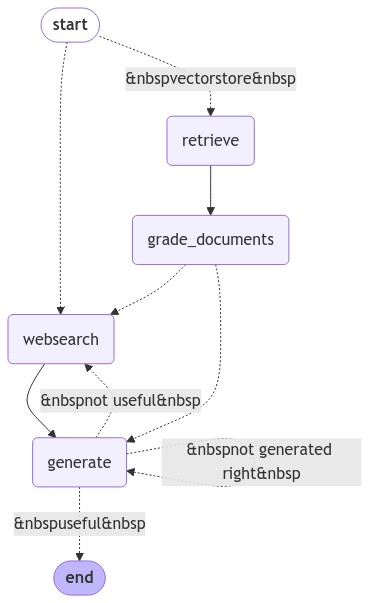

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)